In [59]:
import yfinance as yf
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import shutil

In [60]:
goog = yf.Ticker("GOOG")
historic_price = yf.download("GOOG")
prices = historic_price['Adj Close']

[*********************100%%**********************]  1 of 1 completed


Simple moving average function for feature extraction. Takes in the length of the moving average

In [61]:
MAX_HOLDING = 50

In [62]:
def get_sma(prices, MA):
    sma = []
    for pos1 in range(0, len(prices) - MA):
        sum = 0
        for change in range(MA, 0, -1):
            sum += prices.iloc[pos1 + change]
        sma.append(sum / MA)
    return sma

Standard deviation function for feature extraction. Takes in how long back to look to determine the standard deviation of a given price

In [63]:
def get_sd(prices, time):
    sd = []
    for pos1 in range(0, len(prices) - time):
        sum = 0
        for change in range(time, 0, -1):
            sum += prices.iloc[pos1 + change]
        mean = sum / time
        summa = 0
        for change in range(time, 0, -1):
            summa += (prices.iloc[pos1 + change] - mean) ** 2
        sd.append(math.sqrt(summa / time))
    return sd

Visit https://www.desmos.com/calculator/saxa0jcqds to see how time affects price with each function

In [64]:
time_effect1 = lambda L, x: 1-(x/L)
time_effect2 = lambda L, x: L/(x+L)
time_effect3 = lambda L, x: (-1/(L**2))(x**2)+1
time_effect3 = lambda L, x: -1/((x-L)**2)

In [65]:
answer = []
for pos1 in range(len(prices) - MAX_HOLDING):
    ans = 0
    for pos2 in range(1, MAX_HOLDING):
        ans += (prices.iloc[pos1 + pos2] - prices.iloc[pos1]) * time_effect3(MAX_HOLDING, pos2)
    answer.append(ans)

dp_factors = [answer[0]]
for pos in range(1, len(answer)):
    dp_factors.append(max(abs(answer[pos]), abs(dp_factors[-1])))
    answer[pos] /= dp_factors[pos]
answer = answer[MAX_HOLDING:]
prices = prices[MAX_HOLDING:]

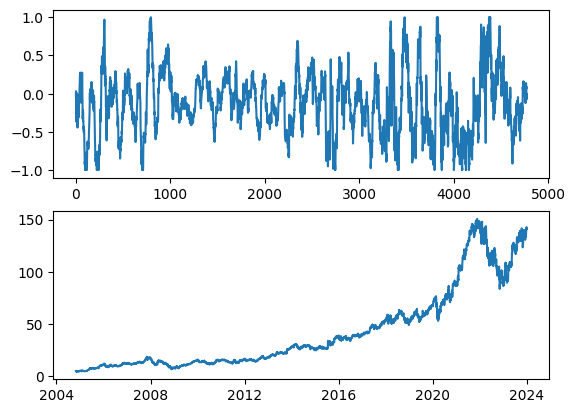

In [66]:
figure, axis = plt.subplots(2)

axis[0].plot(answer)
axis[1].plot(prices)
plt.show()

In [67]:
sma10 = get_sma(prices, 10)
sma30 = get_sma(prices, 20)
sma50 = get_sma(prices, 30)
sma100 = get_sma(prices, 50)
sd10 = get_sd(prices, 10)
sd30 = get_sd(prices, 20)
sd50 = get_sd(prices, 30)
sd100 = get_sd(prices, 50)

largest_view = 50
if MAX_HOLDING < largest_view:
    answer = answer[largest_view - MAX_HOLDING:]

x = []
y = []
for pos in range(0, len(answer)):
    temp = [0] * 200
    x.append([sma10[pos], sma30[pos], sma50[pos], sma100[pos], sd10[pos], sd30[pos], sd50[pos], sd100[pos]])
    ans = (answer[pos] + 1) / 2
    y.append(ans)
x = np.array(x)
y = np.array(y)

In [81]:
x_train, x_test, y_train, y_test = train_test_split(x[:round(len(x)*0.9)], y[:round(len(y)*0.9)], test_size=0.2)

Training and testing dataset includes everything until the last 20% history of the stock. This is done to simulate the neural net never having seen the last 10% of prices so we can test its validity.

In [82]:
def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(8,), name='layers_flatten'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1),
  ])

In [83]:
model = create_model()
model.compile(optimizer='adam',
              loss='mean_absolute_error',)

In [84]:
model.fit(x=x_train, 
          y=y_train, 
          epochs=50, 
          validation_data=(x_test, y_test), 
)

Epoch 1/50
108/108 [==============================] - 2s 6ms/step - loss: 0.4261 - val_loss: 0.5205
Epoch 2/50
108/108 [==============================] - 0s 4ms/step - loss: 0.1706 - val_loss: 0.1184
Epoch 3/50
108/108 [==============================] - 0s 4ms/step - loss: 0.1276 - val_loss: 0.1235
Epoch 4/50
108/108 [==============================] - 0s 4ms/step - loss: 0.1316 - val_loss: 0.1000
Epoch 5/50
108/108 [==============================] - 0s 4ms/step - loss: 0.1152 - val_loss: 0.1042
Epoch 6/50
108/108 [==============================] - 0s 4ms/step - loss: 0.1099 - val_loss: 0.0858
Epoch 7/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0892 - val_loss: 0.1326
Epoch 8/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0891 - val_loss: 0.0815
Epoch 9/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0842 - val_loss: 0.1238
Epoch 10/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0791 - val_loss: 0.0898

In [85]:
predictions = model.predict(x[round(len(x)*0.9):])
dates = prices.keys()

15/15 [==============================] - 0s 4ms/step


2022-05-18 00:00:00
2022-05-19 00:00:00


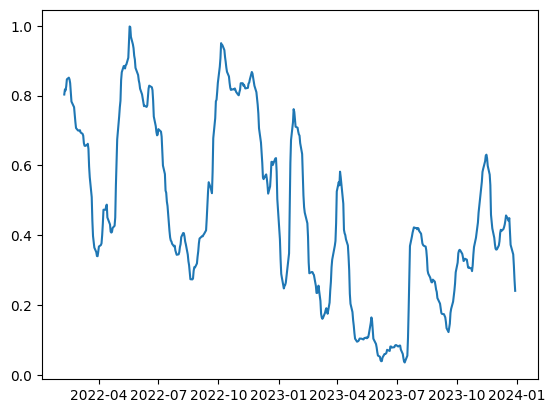

In [94]:
for num in range(len(predictions)):
    if predictions[num] > 0.99:
        print(dates[-(len(predictions) - num)])
plt.plot(dates[-len(predictions):], predictions)
plt.show()

In [16]:
for pos in range(len(predictions)):
    if predictions[pos] > 1.2: 
        print(prices.iloc[pos + round(len(prices)*0.8)], dates[pos + round(len(prices)*0.8)])

55.9900016784668 2020-03-17 00:00:00
54.84000015258789 2020-03-18 00:00:00
55.76449966430664 2020-03-19 00:00:00
53.61600112915039 2020-03-20 00:00:00
52.83100128173828 2020-03-23 00:00:00
56.722999572753906 2020-03-24 00:00:00
55.1245002746582 2020-03-25 00:00:00
58.087501525878906 2020-03-26 00:00:00
55.535499572753906 2020-03-27 00:00:00
57.340999603271484 2020-03-30 00:00:00
58.140499114990234 2020-03-31 00:00:00
55.28099822998047 2020-04-01 00:00:00
56.04199981689453 2020-04-02 00:00:00
54.89400100708008 2020-04-03 00:00:00
59.34600067138672 2020-04-06 00:00:00
59.32550048828125 2020-04-07 00:00:00
60.513999938964844 2020-04-08 00:00:00
60.5724983215332 2020-04-09 00:00:00
60.87799835205078 2020-04-13 00:00:00
115.66000366210938 2022-05-06 00:00:00
113.08399963378906 2022-05-09 00:00:00
114.58450317382812 2022-05-10 00:00:00
113.96099853515625 2022-05-11 00:00:00
113.16100311279297 2022-05-12 00:00:00
116.5155029296875 2022-05-13 00:00:00
114.7925033569336 2022-05-16 00:00:00
116.

In [22]:
for pos in range(len(predictions)):
    if predictions[pos] < -0.7:
        print(prices.iloc[pos + round(len(prices)*0.8)], dates[pos + round(len(prices)*0.8)])

126.62999725341797 2023-06-05 00:00:00
127.91000366210938 2023-06-06 00:00:00
122.94000244140625 2023-06-07 00:00:00
122.66999816894531 2023-06-08 00:00:00


1.2 and -0.7 were chosen as arbiratry "sure" buy and sell points for quick model testing.

In [139]:
ticker = 'GOOG'
path = 'Models/' + ticker + '/'
if not os.path.exists(path):
    os.makedirs(path)
else:
    shutil.rmtree(path)
    os.makedirs(path)
model.save(path)
model.save_weights(path)

INFO:tensorflow:Assets written to: Models/GOOG/assets


INFO:tensorflow:Assets written to: Models/GOOG/assets
